<a href="https://colab.research.google.com/github/denis-spe/Digit-Recognization/blob/v2/digit_recognization_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Digit Recognization With Pytorch</h1>

<h2 style="font-size: 20px;">Import Necessary Libraries and packages</h2>

In [103]:
!pip install torchinfo


In [104]:
import torch
import numpy as np
import pandas as pd
import os, warnings, time
from PIL import Image
from typing import Dict, Iterator
from torchinfo import summary
from torch import nn as nn
import matplotlib.pyplot as plt
from torch import functional as f
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
print("Pytorch Version: ", torch.__version__)

Pytorch Version:  1.11.0+cu113


<h2 style="font-size: 20px;">Configuring The NoteBook</h2>

In [105]:
# Setting the graph style
plt.rc('figure', autolayout=True)
plt.rc(
    'axes', titleweight='bold', 
    titlesize=20, labelweight=700,
    labelsize=13
    )
plt.rc('font', size=15)

def set_seeds(seed: int=0):
    """Sets the Seed into order to same result on every code run"""
    np.random.seed(seed)
    torch.manual_seed(seed)

# Call the set_seeds with default parameter
set_seeds()

# Turning the warnings
warnings.filterwarnings('ignore')

# Use the Gpu if available either cpu will be used
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Using %s" % device)


Using cuda


<h3 style="font-size: 20px;">Setting the variable to be used in model building and training</h3>

In [106]:
BATCH_SIZE=16
EPOCHS = 10
LEARNING_RATE = 1e-3

<h2 style="font-size: 20px;">Above Data</h2>
<p style="font-size: 15px;">
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:
<pre>
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
|   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783
</pre>
</p>

<h2 style="font-size: 20px;">Load Csv File Into Pandas DataFrame</h2>

In [107]:
try:
    from google.colab import drive
    # Connect the google drive
    drive.mount('/gdrive')

    # list the files from drive
    folder_path = '../gdrive/MyDrive/Datasets/MNIST_data'
except ImportError:
    folder_path = '../input/digit-recognizer'

os.listdir(folder_path)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


['train.csv', 'test.csv', 'sample_submission.csv']

In [108]:
# Data Path
train_data_path = folder_path + '/train.csv'
test_data_path = folder_path + '/test.csv'




In [109]:
# Loading dataset into pandas 
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

<h2 style="font-size: 20px;">View The Dataframe</h2>

In [110]:
# First Rows in the train data
print(train_df.shape)
train_df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# First Rows in the test data
print(test_df.shape)
test_df.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2 style="font-size: 20px;">Split Train Dataset Into Train And Validation Set</h2>

In [112]:
mask = np.random.randn(len(train_df)) <= 0.8
train_data = train_df[mask]
valid_data = train_df[~mask]
print(f"Train_data Shape {train_data.shape}\nValid_data: {valid_data.shape}")

Train_data Shape (33172, 785)
Valid_data: (8828, 785)


<h2 style="font-size: 20px;">Creating Dataset</h2>

In [113]:
class CreateDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms: transforms = None, 
                 train: bool =True, normalize: bool = True):
        self.transforms = transforms
        self.train = train
        self.df = df
        self.len = self.df.shape[0]
        self.normalize = normalize

    def __len__(self):
        return self.len

    def __getitem__(self, index: int): 
        if 'label' in self.df.columns:
            image = self.df.iloc[index, 1:].values.reshape(28, 28)
            if self.normalize:
                image = self.df.iloc[index, 1:].values.reshape(28, 28) / 255
            label = self.df.iloc[index, 0]
            if self.transforms:
                image = self.transforms(image).type(torch.float)
            return image, label
        else:
            image = self.df.iloc[index, :].values.reshape(28, 28)
            if self.normalize:
                image = self.df.iloc[index, :].values.reshape(28, 28) / 255
            if self.transforms:
                image = self.transforms(image).type(torch.float)
            return image

In [114]:
# Construct Datasets train_X_set 
train_X_set = CreateDataset(
    train_data, 
    transforms=transforms.Compose([transforms.ToTensor()]))

# Construct valid_X_set dataset
valid_X_set = CreateDataset(
    valid_data, 
    transforms=transforms.Compose([transforms.ToTensor()]))

# Construct test_data 
test_data = CreateDataset(
    test_df, 
    transforms=transforms.Compose([transforms.ToTensor()]))

<h2 style="font-size: 20px;">Placing Dataset Into Dataloader</h2>

In [115]:
# Coupling Datasets with dataloader function
train_dataloader = DataLoader(train_X_set, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_X_set, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

<h2 style="font-size: 20px;">Exploring Datasets</h2>

In [116]:
# Getting the first image and label in the train_dataset
img, label = train_dataloader.dataset[0]

In [117]:
print(f"Data Type for image: {type(img)}")
print(f"Shape of images dataset: {img.size()}")
print(f"Data Type for label: {type(label)}")
print(f"Label {sorted(train_df.loc[:, 'label'].unique())}")

Data Type for image: <class 'torch.Tensor'>
Shape of images dataset: torch.Size([1, 28, 28])
Data Type for label: <class 'numpy.int64'>
Label [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<h2 style="font-size: 20px;">Digits Visualization</h2>

In [118]:
img = next(iter(test_dataloader))

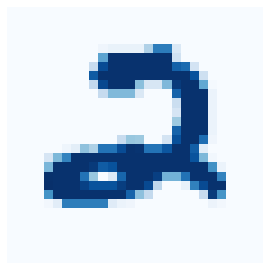

In [119]:

# Visualizing of the one image in the test_dataset
img = next(iter(test_dataloader.dataset))
cmap = plt.get_cmap('Blues')
plt.imshow(img.squeeze(), cmap=cmap)
plt.axis('off')
plt.show()

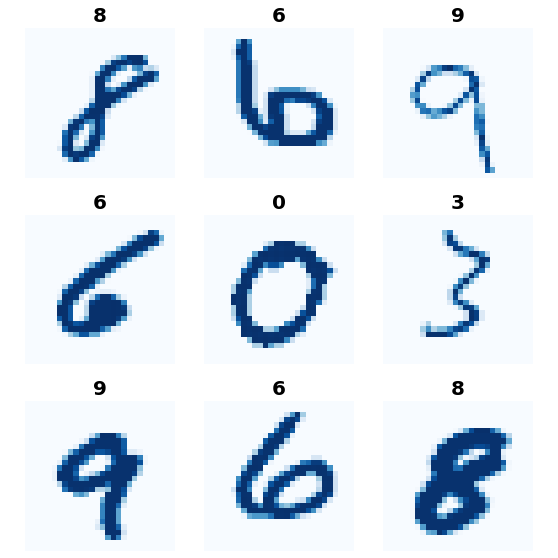

In [120]:
# Create Subplot instance
fig, ax = plt.subplots(figsize=(8, 8))

# Number of columns and rows
NROW = 3
NCOL = 3

# loop over the range of NROW * NCOL starting from 1
for i in range(1, NROW * NROW + 1):
    fig.add_subplot(NROW, NCOL, i)
    
    # Generat random number in range of length of image in the train_dataloader.dataset
    idx = torch.randint(len(train_dataloader.dataset), size=(1,)).item()

    # Get the image from the generated index
    img, label = train_dataloader.dataset[idx]

    # Plot it
    plt.imshow(img.squeeze(), cmap=cmap)
    plt.axis('off')
    plt.title(label)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()

<h2 style="font-size: 20px;">Model Building</h2>

In [121]:
class Model(nn.Module):
    def __init__(self, layers: Iterator, device: any = None ) -> None:
        self.__layers = layers
        super(Model, self).__init__()
        self.__stacked_layers = nn.Sequential(*self.__layers)
        # """
        # Train and evaluate the model 
        # :param model to train:
        # :optim for optimization process:
        # :param loss to adjust gradient from optimizer:
        # """

        # self.lr = lr
        # self.optim = optimizer or torch.optim.Adam(
        #                                            mnist_model.parameters(), 
        #                                            lr=self.lr)
        
        self.device = device

    def forward(self, X):
        return self.__stacked_layers(X)

    def compile(self, optimize: any, loss: any) -> None:
        self.optim = optimize
        self.loss = loss
        self.model = Model(self.__layers).to(self.device)
    
    def train_process(self, data_loader) -> None:
        """
        Train model on train_data
        """
        # Indicating the model to training
        self.model.train()

        # Number of images in  data_loader: size 
        size = len(data_loader.dataset)

        # Initialize the metric variable
        total_acc, total_loss, count_label, current = 0, 0, 0, 0

        start = time.time()
        # iterate over the data_loader
        for batch, (X, y) in enumerate(data_loader):
            # Switch to device 
            X, y = X.to(self.device), y.to(self.device)
       
            # Make prediction
            yhat = self.model(X)
            
            # *** Backpropagation Process ***

            # Compute error by measure the degree of dissimilarity 
            # from obtained result in target
            criterion = self.loss(yhat, y)
            
            # Reset the gradient of the model parameters
            # Gradients by default add up; to prevent double-counting, 
            # we explicitly zero them at each iteration.
            self.optim.zero_grad()
      
            # Back propagate the prediction loss to deposit the gradient of loss
            # for learnable parameters
            criterion.backward()


            # Adjust the parameters by gradient collected in the backward pass
            self.optim.step()

            # Count number of labels
            count_label += len(y)

            # sum each loss to total_loss variable
            total_loss += criterion.item()

            _, predict = torch.max(yhat, 1)

            # Add every accuracy on total_acc
            total_acc += (predict == y).sum().item()
            
            if batch % 100 == 0:
                print(".", end=" ")
                current += (batch / size)


        stop = time.time()
        time_taken = round(stop - start, 3)

        return (total_loss / count_label,
                 total_acc / count_label, time_taken,
                int(round(current * 100))
                )

    def evaluate (self, data_loader) -> None:
        """ 
        Evaluation model with validation data
        """
        # Directing model to evaluation process
        self.model.eval()

        # Instaniate metric variables
        total_loss, total_acc, count_labels = 0, 0, 0

        # Disabling gradient calculation
        with torch.no_grad():
            for X, y in data_loader:
                # Set to device
                X, y = X.to(self.device), y.to(self.device)

                # Make prediction
                pred = self.model(X)

                # Compute the loss(error)
                criterion = self.loss(pred, y)

                # Add number of label to count_labels
                count_labels += len(y)

                # Add criterion loss to total_loss
                total_loss += criterion.item()

                # Sum accuracy to total_acc
                total_acc += (pred.argmax(1) == y).sum().item()

            # Finally return total_loss and total_acc which each is divded by
            # count_labels
            return total_loss / count_labels, total_acc /count_labels

    def fit(
        self, 
        train_data: DataLoader,
        epochs: int = 1,
        validation_data: DataLoader = None 
        ) -> None:
        """
        The Fit method make use of train data and
        validation data if provided
        :param train_data. Data for training the model:
        :param epoch. Number of iteration:
        :param validation_data. Data to validate how well the model preformed:
        """
        # Initializing variable for storing metric score
        metrics = {}
        acc_list = []
        loss_list = []
        valid_acc_list = []
        valid_loss_list = []

        # loop throught the epoch
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs} ")
            train = self.train_process(train_data)
            # Instaniate train loss and accuracy
            train_loss = round(train[0], 6)
            train_acc = round(train[1], 5)
            print(f"{int(train[2])}s {train[3]}ms/steps - loss: {train_loss} - acc: {train_acc} ", end = "")
            # Storing the model score
            acc_list.append(train_acc)
            loss_list.append(train_loss)

            if validation_data:
                valid = self.evaluate(validation_data)
                # Instaniate train loss and accuracy
                valid_loss = round(valid[0], 6)
                valid_acc = round(valid[1], 4)
                print(f"- val_loss: {valid_loss} - val_acc: {valid_acc} ", end = "")
                # Store the score 
                valid_loss_list.append(valid_loss)
                valid_acc_list.append(valid_acc)

        metrics["acc"] = acc_list
        metrics["loss"] = loss_list
        if validation_data:
            metrics["val_acc"] = valid_acc_list
            metrics["val_loss"] = valid_loss_list
        return metrics
    
    def predict(self, y) -> torch.tensor:
        # list storage for predictions
        predictions = []

        # Indicate to evalation process
        #self.model.eval()

        # Don't use the gradient
        with torch.no_grad():

            # Loop over the values in y
            for val in y.dataset:

                # switch to device
                val = val.to(self.device)

                # Make prediction
                probability = self.model(val)

                # probability variable returns probability
                # Therefor convert it to actual value
                pred = torch.argmax(probability, 1).item()

                # Add prediction to predictions list
                predictions.append(pred)
        return predictions


In [122]:
# Initialize the TrainEvaluationModel: train_eval
model = Model([
               # Transpose Input data
               nn.Flatten(),

               # Input layer
               nn.Linear(in_features=28*28, out_features=256),
               nn.ReLU(), # Activation function
               nn.Dropout(.4),

               # First hidden layer
               nn.Linear(in_features=256, out_features=256),
               nn.ReLU(), # Activation function
               nn.Dropout(.4), # Drop same pixal

               # Output layer
               nn.Linear(in_features=256, out_features=10),
               nn.Softmax()

               ])
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       200,960
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       65,792
│    └─ReLU: 2-6                         --
│    └─Dropout: 2-7                      --
│    └─Linear: 2-8                       2,570
│    └─Softmax: 2-9                      --
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0

In [123]:
model.compile(
    optimize=torch.optim.Adam(model.parameters()),
    loss=nn.CrossEntropyLoss() 
    )

In [124]:
history = model.fit(train_dataloader, epochs=EPOCHS, validation_data=valid_dataloader)


Epoch 1/10 
. . . . . . . . . . . . . . . . . . . . . 33s 63ms/steps - loss: 0.100625 - acc: 0.86079 - val_loss: 0.095927 - val_acc: 0.9287 
Epoch 2/10 
. . . . . . . . . . . . . . . . . . . . . 23s 63ms/steps - loss: 0.096558 - acc: 0.91794 - val_loss: 0.09553 - val_acc: 0.9336 
Epoch 3/10 
. . . . . . . . . . . . . . . . . . . . . 24s 63ms/steps - loss: 0.095903 - acc: 0.92774 - val_loss: 0.094912 - val_acc: 0.9419 
Epoch 4/10 
. . . . . . . . . . . . . . . . . . . . . 24s 63ms/steps - loss: 0.095589 - acc: 0.93235 - val_loss: 0.09481 - val_acc: 0.9453 
Epoch 5/10 
. . . . . . . . . . . . . . . . . . . . . 25s 63ms/steps - loss: 0.095475 - acc: 0.93437 - val_loss: 0.094546 - val_acc: 0.9493 
Epoch 6/10 
. . . . . . . . . . . . . . . . . . . . . 26s 63ms/steps - loss: 0.095272 - acc: 0.93721 - val_loss: 0.094439 - val_acc: 0.9506 
Epoch 7/10 
. . . . . . . . . . . . . . . . . . . . . 26s 63ms/steps - loss: 0.095177 - acc: 0.93853 - val_loss: 0.094622 - val_acc: 0.9476 
Epoch 8/10 
. 

<h2 style="font-size: 20px;">Model Evaluation</h2>

In [125]:
evalutate = model.evaluate(valid_dataloader)
print(f"Loss: {round(evalutate[0], 4)} - Accurary: {round(evalutate[1], 3)}%")

Loss: 0.0945 - Accurary: 0.95%


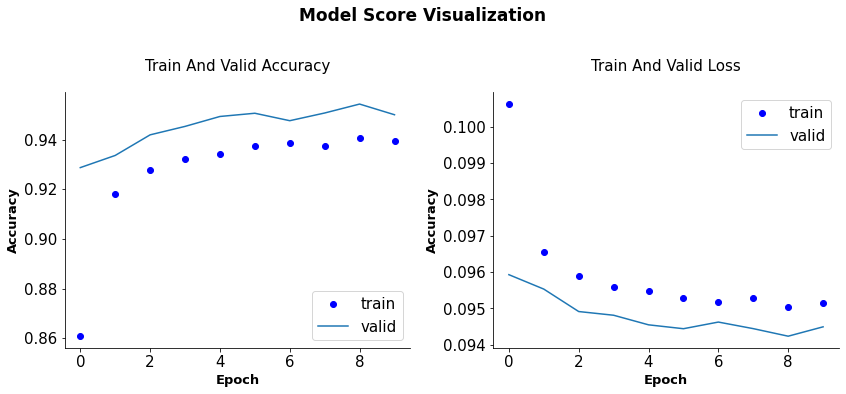

In [126]:
def plot_metrics(history: Dict, n_epoch: int) -> plt.figure:
    """
    Return matplotlib figure with accuracy score 
    and loss score visualization
    parameter:
    -----------------------
    :param history, Dictionary with model loss and accuracy:
    :return plt.figure with subplots of train and validation score:
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    epochs = list(range(n_epoch))
    ax[0].plot(epochs, history["acc"], "ob")
    ax[0].plot(epochs, history["val_acc"])

    ax[1].plot(epochs, history["loss"], "ob")
    ax[1].plot(epochs, history["val_loss"])

    for i in range(2):
        ax[i].set_ylabel(f"Accuracy")
        ax[i].set_xlabel("Epoch")
        
        # Hide the right and top spines
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].legend(["train", "valid"])

    ax[0].set_title(f"Train And Valid Accuracy".title(), weight=500, y=1.06, size=15)
    ax[1].set_title(f"Train And Valid loss".title(), weight=500, y=1.06, size=15)
    fig.suptitle("Model Score Visualization", y=1.1, weight=800, size=17)
plot_metrics(history, n_epoch=EPOCHS)

# Submission

In [127]:
# make predictions
pred = model.predict(test_dataloader)

In [128]:
submission=pd.read_csv(folder_path + '/sample_submission.csv')
submission['Label']=pred
submission.to_csv('pytorch_prediction6.csv', index=False)